# Стоимость подержанного автомобиля

## Постановка задачи

Многие знают про маркетплейсы где продаются б/у вещи, на которых есть возможность недорого купить качественную и полезную вещь. Но всегда волнует вопрос - кто и как устанавливает цену, и какие его характеристики больше всего влияют на итоговую стоимость продажи?! Вопрос становиться особо актуальным, если речь идет про дорогие товары, например про автомобили!

Необходимо разработать и обучить ML модель, которая по табличным данным предсказывает стоимость автомобиля.


## Описание данных

Date: Год выпуска автомобиля.

Make: Марка автомобиля.

Model: издание автомобиля определенной марки.

Trim: Уровни отделки салона автомобиля — это просто разные версии модели.

Body: Тип кузова транспортного средства относится к форме и модели конкретной марки автомобиля.

Transmission: механизм, который передает мощность от двигателя к колесам.

VIN: идентификационный номер транспортного средства.

State: штат, в котором автомобиль выставлен на аукцион.

Condition: Состояние автомобилей на момент аукциона.

Odometer: расстояние, пройденное автомобилем с момента выпуска.

Color: Цвет кузова автомобиля.

Interior: Цвет салона автомобиля.

Seller: Продавец автомобиля, автосалоны.

mmr: Рекорд рынка Manhiem, рыночная оценочная цена автомобилей.

sellingprice: цена, по которой автомобиль был продан на аукционе.

saledate: Дата продажи автомобиля.


# Предварительные настройки

In [1]:
# импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import warnings

In [2]:
# предварительные настройки библиотек
pd.options.mode.chained_assignment = None
warnings.simplefilter(action='ignore', category=FutureWarning)


In [3]:
# импорт функций предобработки
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

In [221]:
# модели и инструменты для работы с ними
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import make_scorer

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV

In [5]:
# зададим константы
FIGSIZE = (9, 6)
RANDOM_STATE = 12345

# Исследовательский анализ данных

## Предварительное знакомство с данными

In [6]:
def first_look(df, lines=5):
    '''выводит основные показатели для набора данных
    Принимает следующие параметры:
    df - набор данных
    lines - количество строк для вывода
    '''
    print(f'Первые строки ({lines} шт):')
    print(df.head(lines))
    print()
    print('Общее описание набора данных:\n')
    print(df.info())
    print()
    print('Наличие пропусков в данных:\n')
    print(df.isna().sum())
    print()
    print('Наличие дубликатов в данных:', df.duplicated().sum())

Загрузим тренировочный датасет и проведем анализ данных.

In [7]:
# data = pd.read_csv('/kaggle/input/used-cars-price-prediction-19ds/train.csv')
data = pd.read_csv('train.csv')

In [8]:
# test = pd.read_csv('/kaggle/input/used-cars-price-prediction-19ds/test.csv')
test = pd.read_csv('test.csv')

In [9]:
first_look(data)

Первые строки (5 шт):
   year    make   model    trim   body transmission                vin state  \
0  2011    Ford    Edge     SEL    suv    automatic  2fmdk3jc4bba41556    md   
1  2014    Ford  Fusion      SE  Sedan    automatic  3fa6p0h75er208976    mo   
2  2012  Nissan  Sentra  2.0 SL  sedan    automatic  3n1ab6ap4cl698412    nj   
3  2003  HUMMER      H2    Base    suv    automatic  5grgn23u93h101360    tx   
4  2007    Ford  Fusion     SEL  Sedan    automatic  3fahp08z17r268380    md   

   condition  odometer  color interior                      seller  \
0        4.2  111041.0  black    black          santander consumer   
1        3.5   31034.0  black    black       ars/avis budget group   
2        2.2   35619.0  black    black          nissan-infiniti lt   
3        2.8  131301.0   gold    beige  wichita falls ford lin inc   
4        2.0  127709.0  black    black                purple heart   

   sellingprice                                 saledate  
0         12500  

In [10]:
first_look(test)

Первые строки (5 шт):
   year       make         model      trim      body transmission  \
0  2005   Cadillac           CTS      Base     Sedan    automatic   
1  2014        GMC  Savana Cargo      2500       Van          NaN   
2  2013     Nissan        Murano         S       SUV    automatic   
3  2013  Chevrolet        Impala  LS Fleet     Sedan    automatic   
4  2013     Nissan         Titan        SV  Crew Cab    automatic   

                 vin state  condition  odometer   color interior  \
0  1g6dp567450124779    ca        2.7  116970.0  silver    black   
1  1gtw7fca7e1902207    pa        4.4    6286.0   white     gray   
2  jn8az1mw6dw303497    oh        4.6   11831.0    gray    black   
3  2g1wf5e34d1160703    fl        2.3   57105.0  silver    black   
4  1n6aa0ec3dn301209    tn        2.9   31083.0   black    black   

                                             seller  \
0                            lexus of stevens creek   
1                                           

Пропусков не содержат следующие характеристики:
- год выпуска автомобиля,
- идентификационный номер транспортного средства,
- штат, в котором выставлен на продажу автомобиль
- продавец
- цена, по которой автомобиль был продан на аукционе
- дата продажи

Самое большое количество пропусков содержится в  данных о типе коробки передач (почти 12 %) и типе кузова (около 2 %).

## Заполнение пропусков и обработка дубликатов

Видно, что датасет, доступный для обучения, очень сильно по своим характеристикам похож на тестовый. Поэтому при обработке пропусков и дубликатов:

- будем одновременно обрабатывать обучающий датасет и тестовый;

- закономерности данных, необходимые для выработки правил заполнения пропусков, будем вырабатывать на тренировочном датасете, а применять к обоим датасетам (по той же логике, по которой устроены трансформеры данных библиотеки Scikit Learn)

- если придется удалить часть обучающих данных, то это будет сделано в целях уменьшений их зашумленности и повышения качества модели


Так как модели придется вырабатывать прогнозы на данных, которые тоже могут содержать отсутствующие значения, то часть пропусков заполним значением 'unknown'. Это можно сделать с данными о модели, производителе, цвете кузова и салона, уровне отделки салона.

В некоторых случаях кажется возможным заполнить пропуски по имеющимся данным других столбцов. Например, зная модель машины, можно заполнить пропуски в данных о типе кузова и т.п. Здесь мы сталкиваемся с проблемой неявных дубликатов – для некоторых строк производители и модели написаны с заглавной буквы, для других – нет. Исправим это.

## Модель автомобиля

In [11]:
# количество уникальных значений
len(data['model'].unique())

960

In [12]:
# заменяем регистр символов в данных о модели
data['model'] = data['model'].str.lower()
test['model'] = test['model'].str.lower()

In [13]:
# количество уникальных значений после замены
len(data['model'].unique())

840

Видим, что количество уникальных значений сократилось.

In [14]:
# количество пропусков
data['model'].isna().sum(), test['model'].isna().sum()

(8123, 2079)

In [15]:
# заполняем пропуски
data['model'].fillna('unknown', inplace=True)
test['model'].fillna('unknown', inplace=True)

In [16]:
# контроль количества пропусков
data['model'].isna().sum(), test['model'].isna().sum()

(0, 0)

В данных о модели мы отработали неявные дубликаты и удалили пропуски.

## Производитель авто

Посмотрим на уникальные значения в этом столбце.

In [17]:
data['make'].unique()

array(['Ford', 'Nissan', 'HUMMER', 'Lincoln', 'pontiac', 'Hyundai', nan,
       'Buick', 'Chevrolet', 'Honda', 'Acura', 'Cadillac', 'GMC', 'Saab',
       'Dodge', 'Mercedes-Benz', 'Toyota', 'Volkswagen', 'BMW',
       'Infiniti', 'Chrysler', 'Kia', 'Jaguar', 'Subaru', 'Jeep', 'Lexus',
       'mercedes', 'Scion', 'FIAT', 'Suzuki', 'Mazda', 'Volvo', 'Audi',
       'MINI', 'Isuzu', 'Mitsubishi', 'smart', 'Pontiac', 'Porsche',
       'subaru', 'ford', 'Land Rover', 'chrysler', 'Saturn', 'mazda',
       'dodge', 'Ram', 'Oldsmobile', 'hyundai', 'Mercury', 'Bentley',
       'toyota', 'lincoln', 'Fisker', 'nissan', 'chevrolet', 'honda',
       'porsche', 'mitsubishi', 'lexus', 'bmw', 'Maserati', 'acura',
       'jeep', 'mercury', 'Tesla', 'landrover', 'vw', 'cadillac', 'buick',
       'gmc truck', 'land rover', 'volkswagen', 'Rolls-Royce', 'audi',
       'Ferrari', 'suzuki', 'Plymouth', 'oldsmobile', 'Lamborghini',
       'gmc', 'Geo', 'ford truck', 'Aston Martin', 'plymouth', 'Daewoo',
      

In [18]:
# количество уникальных значений
len(data['make'].unique()), len(test['make'].unique())

(93, 86)

In [19]:
# заменяем регистр символов в данных о производителе
data['make'] = data['make'].str.lower()
test['make'] = test['make'].str.lower()

In [20]:
# количество уникальных значений после замены
len(data['make'].unique()), len(test['make'].unique())

(63, 59)

Видим, что количество уникальных значений сократилось, но среди них встречаются неявные дубликаты, так как названия некоторых производителей допускают несколько вариантов написания.

Создадим словарь для замены и проконтролируем количество уникальных значений.

In [21]:
# словарь для замены неявных дубликатов
make_to_replace = {
    "mercedes-b" : "mercedes",
    "mercedes-benz" : "mercedes",
    "land rover" : "landrover",
    "vw" : "volkswagen",
    "gmc truck" : "gmc",
    "dodge tk" : "dodge",
    "mazda tk" : "mazda",
    "ford truck" : "ford"
}

# заменяем повторяющиеся значения на одно
data['make'].replace(make_to_replace, inplace=True)
test['make'].replace(make_to_replace, inplace=True)

In [22]:
# количество уникальных значений в столбце
len(data['make'].unique()), len(test['make'].unique())

(55, 56)

Пропуски заменим значением unknown, так как данные, поступающие модели для составления прогнозов, также могут содержать пропуски.

In [23]:
# количество пропусков
data['make'].isna().sum(), test['model'].isna().sum()

(8043, 0)

In [24]:
# заполняем пропуски
data['make'].fillna('unknown', inplace=True)
test['make'].fillna('unknown', inplace=True)

In [25]:
# контроль количества пропусков
data['model'].isna().sum(), test['model'].isna().sum()

(0, 0)

Таким образом, мы провели предварительную обработку столбцов, содержащих ключевую информацию об автомобиле. Продолжим обработку, опираясь  на проделанные изменения.

In [26]:
data.isna().sum()

year                0
make                0
model               0
trim             8337
body            10393
transmission    51461
vin                 0
state               0
condition        9405
odometer           69
color             586
interior          586
seller              0
sellingprice        0
saledate            0
dtype: int64

### Тип коробки передач

Некоторые модели автомобилей выпускаются в двух вариантах: с ручной и автоматической коробками передач. При заполнении пропусков будем опираться на обучающие данные и отберем те модели, в записях о которых содержатся только упоминания об одном типе коробки передач и значение nan. Для таких моделей заполним пропуски значением типа трансмиссии, характерным для данной модели. В остальных случаях нет возможности однозначно выбрать значение для заполнения пропуска, поэтому впишем в пустые ячейки unknown.

In [27]:
data['transmission'].unique()

array(['automatic', nan, 'manual'], dtype=object)

In [28]:
# списки моделей по типу коробки передач
list_of_models_a = []
list_of_models_m = []

for model in data.query('transmission.isna()')['model'].unique():
    unique_transmissions = data[data['model'] == model]['transmission'].unique()
    if len(unique_transmissions) == 2: # т.е. только nan и еще одно
        if 'automatic' in unique_transmissions:
            list_of_models_a.append(model)
        elif 'manual' in unique_transmissions:
            list_of_models_m.append(model)

len(list_of_models_a), len(list_of_models_m)

(369, 4)

Возьмем индексы строк, в которых есть данные о моделях, для которых в датасете только один тип коробки передач. В этих строках заполним пропуски.

In [29]:
na_before = data['transmission'].isna().sum()
na_before

51461

In [30]:
# поменяем пропуски на значение 'automatic'
indexes = data.query('transmission.isna() and model in @list_of_models_a').index
data.loc[indexes, 'transmission'] = 'automatic'

In [31]:
# поменяем пропуски на значение 'automatic'
indexes = test.query('transmission.isna() and model in @list_of_models_a').index
test.loc[indexes, 'transmission'] = 'automatic'

In [32]:
# поменяем пропуски на значение 'manual'
indexes = data.query('transmission.isna() and model in @list_of_models_m').index
data.loc[indexes, 'transmission'] = 'manual'

In [33]:
# поменяем пропуски на значение 'manual'
indexes = test.query('transmission.isna() and model in @list_of_models_m').index
test.loc[indexes, 'transmission'] = 'manual'

In [34]:
# контроль количества пропусков
na_after = data['transmission'].isna().sum()
na_after

35683

In [35]:
(na_before - na_after) / na_before * 100

30.660111540778455

Таким образом получилось закрыть 30 % пропусков о типе коробки передач. Для остальных случаев можно заменить пропуски значением unknown.

In [36]:
data['transmission'].fillna('unknown', inplace=True)
test['transmission'].fillna('unknown', inplace=True)

In [37]:
# контроль количества пропусков
data['transmission'].isna().sum(), test['transmission'].isna().sum()

(0, 0)

## Пропуски. Тип кузова

Сначала посмотрим список уникальных значений.

In [38]:
 data['body'].unique()

array(['suv', 'Sedan', 'sedan', nan, 'SUV', 'wagon', 'Minivan',
       'Extended Cab', 'Regular Cab', 'Coupe', 'SuperCrew', 'Wagon',
       'convertible', 'Crew Cab', 'SuperCab', 'Convertible', 'Hatchback',
       'minivan', 'hatchback', 'G Coupe', 'G Convertible', 'coupe',
       'Access Cab', 'G Sedan', 'regular cab', 'e-series van',
       'supercrew', 'Quad Cab', 'tsx sport wagon', 'Van', 'g sedan',
       'E-Series Van', 'CTS Coupe', 'Koup', 'King Cab', 'extended cab',
       'double cab', 'Elantra Coupe', 'koup', 'access cab', 'Double Cab',
       'crew cab', 'quad cab', 'g coupe', 'CrewMax Cab', 'supercab',
       'g convertible', 'Genesis Coupe', 'van', 'G37 Coupe', 'club cab',
       'Beetle Convertible', 'Mega Cab', 'regular-cab', 'Xtracab',
       'cts coupe', 'genesis coupe', 'Club Cab', 'q60 coupe', 'mega cab',
       'crewmax cab', 'Promaster Cargo Van', 'king cab', 'CTS-V Coupe',
       'TSX Sport Wagon', 'CTS Wagon', 'Cab Plus 4', 'G37 Convertible',
       'Transit Van'

Изменим регистр всех символов на нижний.

In [39]:
data['body'] = data['body'].str.lower()
test['body'] = test['body'].str.lower()

In [40]:
data['body'].unique()

array(['suv', 'sedan', nan, 'wagon', 'minivan', 'extended cab',
       'regular cab', 'coupe', 'supercrew', 'convertible', 'crew cab',
       'supercab', 'hatchback', 'g coupe', 'g convertible', 'access cab',
       'g sedan', 'e-series van', 'quad cab', 'tsx sport wagon', 'van',
       'cts coupe', 'koup', 'king cab', 'double cab', 'elantra coupe',
       'crewmax cab', 'genesis coupe', 'g37 coupe', 'club cab',
       'beetle convertible', 'mega cab', 'regular-cab', 'xtracab',
       'q60 coupe', 'promaster cargo van', 'cts-v coupe', 'cts wagon',
       'cab plus 4', 'g37 convertible', 'transit van', 'q60 convertible',
       'cab plus', 'ram van', 'granturismo convertible', 'cts-v wagon'],
      dtype=object)

Часть названий повторяется, к ним прибавляются несущественные детали, которые можно опустить.

In [41]:
data['body'].replace('koup', 'coupe', inplace=True)
test['body'].replace('koup', 'coupe', inplace=True)

In [42]:
# напишем функцию, котрая убирает несущественные детали из значений столбца 'body'
def clean_body_type(row):
    '''
    сокращает название типа кузова автомобиля
    '''
    try:
        body_types = [
            'cab',
            'convertible',
            'coupe',
            'sedan',
            'van',
            'wagon'
        ]
        for b_type in body_types:
            if b_type in row:
                return b_type
        return row
    except:
        return row

In [43]:
data['body'] = data['body'].apply(clean_body_type)
test['body'] = test['body'].apply(clean_body_type)

In [44]:
# финальный список уникальных значений
data['body'].unique()

array(['suv', 'sedan', nan, 'wagon', 'van', 'cab', 'coupe', 'supercrew',
       'convertible', 'hatchback'], dtype=object)

Тип кузова можно частично восстановить по модели автомобиля. Отберем те модели, для которых в данных содержится (кроме nan) только один тип кузова.

In [45]:
# словарь моделей и body
df = data.query('not body.isna()')

model_and_body_type = {}
for model in data['model'].unique():
    list_of_unique_body_types = df[(df['model'] == model)]['body'].unique()
    if (len(list_of_unique_body_types) == 1) and (model != 'unknown'):
        model_and_body_type[model] = list_of_unique_body_types[0]

In [46]:
model_and_body_type

{'edge': 'suv',
 'fusion': 'sedan',
 'sentra': 'sedan',
 'h2': 'suv',
 'mkz': 'sedan',
 'escape': 'suv',
 'freestyle': 'wagon',
 'lucerne': 'sedan',
 'windstar': 'van',
 'silverado 1500': 'cab',
 'murano': 'suv',
 'equinox': 'suv',
 'mdx': 'suv',
 'cts': 'sedan',
 'srx': 'suv',
 'yukon': 'suv',
 'explorer': 'suv',
 'charger': 'sedan',
 'armada': 'suv',
 'gl-class': 'suv',
 'avalon': 'sedan',
 'tahoe': 'suv',
 'malibu': 'sedan',
 'flex': 'wagon',
 'q50': 'sedan',
 '300': 'sedan',
 'sonata': 'sedan',
 'envoy xl': 'suv',
 'rogue': 'suv',
 'maxima': 'sedan',
 'xf': 'sedan',
 'grand caravan': 'van',
 'cherokee': 'suv',
 'impala': 'sedan',
 'optima': 'sedan',
 'expedition': 'suv',
 'is 250': 'sedan',
 'mks': 'sedan',
 'veloster': 'hatchback',
 'golf': 'hatchback',
 'rav4': 'suv',
 'five hundred': 'sedan',
 'g coupe': 'coupe',
 'grand cherokee': 'suv',
 'g convertible': 'convertible',
 'tacoma': 'cab',
 'xa': 'hatchback',
 'g sedan': 'sedan',
 'tl': 'sedan',
 'liberty': 'suv',
 'soul': 'wagon

Для тех авто, где корпус можно однозначно определить по модели, проведем заполнение отсутствующих значений.

In [47]:
# контроль количества пропусков
na_before = data['body'].isna().sum()
na_before

10393

In [48]:
# заполняем пропуски типу кузова
for model in model_and_body_type.keys():
    data.loc[(data['model'] == model) & (data['body'].isna()), 'body'] = model_and_body_type[model]

In [49]:
# заполняем пропуски типу кузова
for model in model_and_body_type.keys():
    test.loc[(test['model'] == model) & (test['body'].isna()), 'body'] = model_and_body_type[model]

In [50]:
# контроль количества пропусков
na_after = data['body'].isna().sum()
na_after

9141

In [51]:
(na_before - na_after) / na_before * 100

12.046569806600596

Количество пропусков сократилось на 12%. Остальные пропуски заполним значением 'unknown'.

In [52]:
data['body'].fillna('unknown', inplace=True)
test['body'].fillna('unknown', inplace=True)

In [53]:
# контроль количества пропусков
data['body'].isna().sum(), test['body'].isna().sum()

(0, 0)

## Пропуски. Цвет

Посмотрим на уникальные значения в столбце с цветом кузова.

In [54]:
data['color'].unique()

array(['black', 'gold', 'silver', 'blue', 'white', 'gray', '—', 'red',
       'brown', 'green', 'beige', 'orange', nan, 'off-white', 'burgundy',
       'yellow', 'charcoal', 'purple', 'turquoise', 'lime', 'pink'],
      dtype=object)

Видим, что часть пропусков имеет вид nan, а часть представляют собой строку и прочерком. Заменим все эти значения на 'unknown'.

In [55]:
# контроль количества пропусков
data['color'].isna().sum()

586

In [56]:
# словарь для замены пропусков
color_to_replace = {
    "—" : "unknown",
    np.nan : "unknown"
}

# замена
data['color'].replace(color_to_replace, inplace=True)
test['color'].replace(color_to_replace, inplace=True)

In [57]:
# контроль количества пропусков
data['color'].isna().sum(), test['color'].isna().sum()

(0, 0)

Пропуски обработаны полностью.

## Пропуски. Цвет салона автомобиля

Посмотрим, какие уникальные значения хранятся в данном столбце.

In [58]:
data['interior'].unique()

array(['black', 'beige', 'gray', 'tan', 'brown', '—', 'off-white', nan,
       'blue', 'white', 'silver', 'red', 'green', 'gold', 'purple',
       'orange', 'burgundy', 'yellow'], dtype=object)

Пропуски имеют вид не только nan, но и '-'. Можно оба эти значения заменить на 'unknown'. Тогда, если цвет салона оказывает влияние на цену, то модель сможет выделить закономерность более полно.

In [59]:
# контроль количества пропусков
data['interior'].isna().sum()

586

In [60]:
# замена
data['interior'].replace(color_to_replace, inplace=True)
test['interior'].replace(color_to_replace, inplace=True)

In [61]:
# контроль количества пропусков
data['interior'].isna().sum(), test['interior'].isna().sum()

(0, 0)

## Пропуски. Уровень отделки

Посмотрим, какие уникальные значения хранятся в данном столбце.

In [62]:
data['trim'] = data['trim'].str.lower()
test['trim'] = test['trim'].str.lower()


In [63]:
data['trim'].unique()

array(['sel', 'se', '2.0 sl', ..., '2.5 x l.l.bean edition',
       '3500 high roof 140 wb', '4x4 v6 xlt sport'], dtype=object)

In [64]:
len(data['trim'].unique())

1851

In [65]:
# проверим, отмечены ли пропуски прочерком
'-' in data['trim'].unique()

False

В таком случае просто заменим отсутствующие данные значением unknown.

In [66]:
# контроль количества пропусков
data['trim'].isna().sum()

8337

Пропуски можно заменить значением unknown.

In [67]:
data['trim'].fillna('unknown', inplace=True)
test['trim'].fillna('unknown', inplace=True)

In [68]:
# контроль количества пропусков
data['trim'].isna().sum(), test['trim'].isna().sum()

(0, 0)

## Пропуски. Пробег

In [69]:
# количество пропусков в данных о пробеге
data['odometer'].isna().sum()

69

Пропуски в данных о пробеге можно заполнить медианным значением пробега для каждого года.

In [70]:
# найдем медианное значение пробега по годам
odometr_median = data.groupby('year')['odometer'].median()
odometr_median

year
1982     85738.0
1983     42697.0
1984     91430.5
1985     75783.0
1986     97443.0
1987    144990.0
1988    100459.0
1989    142761.0
1990    127085.0
1991    166442.0
1992    158267.0
1993    165196.5
1994    165653.0
1995    165081.5
1996    161980.0
1997    169735.0
1998    165260.5
1999    159477.0
2000    154808.0
2001    149396.0
2002    144202.0
2003    137379.0
2004    131083.0
2005    123136.5
2006    115004.0
2007    107604.0
2008     97381.5
2009     88588.5
2010     76853.0
2011     52912.0
2012     37493.0
2013     34814.0
2014     19210.0
2015     11594.5
Name: odometer, dtype: float64

In [71]:
# для каждого года заполняем пропуск медианой
for year in data['year'].unique():
    data.loc[(data['year'] == year) & (data['odometer'].isna()), 'odometer'] = odometr_median[year]

In [72]:
# для каждого года заполняем пропуск медианой
for year in test['year'].unique():
    test.loc[(test['year'] == year) & (test['odometer'].isna()), 'odometer'] = odometr_median[year]

In [73]:
# проверяем количество пропусков
data['odometer'].isna().sum(), test['odometer'].isna().sum()

(0, 0)

## Пропуски. Состояние авто

Пропуски в данных о состоянии авто можно также заполнить медианными значениями в зависимости от года выпуска

In [74]:
# проверяем количество пропусков
data['condition'].isna().sum()

9405

In [75]:
# найдем медианное значение пробега по годам
condition_median = data.groupby('year')['condition'].median()
condition_median

year
1982    2.0
1983    3.0
1984    2.5
1985    2.0
1986    1.0
1987    2.5
1988    2.0
1989    2.0
1990    2.0
1991    2.0
1992    2.0
1993    2.0
1994    2.0
1995    2.0
1996    2.0
1997    2.0
1998    2.0
1999    2.0
2000    2.0
2001    2.0
2002    2.2
2003    2.4
2004    2.5
2005    2.6
2006    2.7
2007    2.8
2008    3.0
2009    3.2
2010    3.4
2011    3.7
2012    3.8
2013    3.9
2014    4.2
2015    4.4
Name: condition, dtype: float64

In [76]:
# для каждого года заполняем пропуск медианой
for year in data['year'].unique():
    data.loc[(data['year'] == year) & (data['condition'].isna()), 'condition'] = condition_median[year]

In [77]:
# для каждого года заполняем пропуск медианой
for year in test['year'].unique():
    test.loc[(test['year'] == year) & (test['condition'].isna()), 'condition'] = condition_median[year]

In [78]:
# проверяем количество пропусков
data['condition'].isna().sum(), test['condition'].isna().sum()

(0, 0)

In [79]:
data.isna().sum()

year            0
make            0
model           0
trim            0
body            0
transmission    0
vin             0
state           0
condition       0
odometer        0
color           0
interior        0
seller          0
sellingprice    0
saledate        0
dtype: int64

In [80]:
test.isna().sum()

year            0
make            0
model           0
trim            0
body            0
transmission    0
vin             0
state           0
condition       0
odometer        0
color           0
interior        0
seller          0
saledate        0
dtype: int64

## Вывод

Таким образом на этапе предварительной обработка данных мы удалили неявные дубликаты и пропуски во всех имеющихся данных.

Часть пропусков заполнено с опорой на имеющиеся данные:
* тип коробки передач и кузова заполнили с опорой на характеристики конкретных моделей;
* пропуски в данных о пробеге и состоянии автомобиля – медианным значением в зависимости от года выпуска авто.

# Разведочный анализ

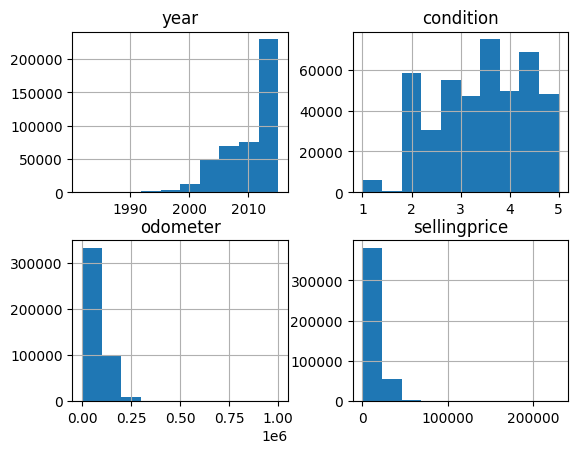

In [81]:
# гистограммы для числовых характеристик
data.hist();

Посмотрим на отдельные характеристики подробнее.

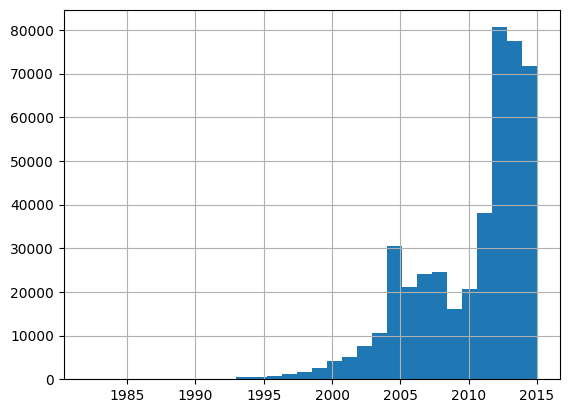

In [82]:
# год выпуска автомобиля
data['year'].hist(bins=30);

In [83]:
# процент количества авто, выпущенных до 1995 года
data[data['year'] < 1995].shape[0] / data.shape[0] * 100

0.16786450903606248

In [84]:
# процент количества авто, выпущенных после  2010 года
data[data['year'] > 2010].shape[0] / data.shape[0] * 100

60.874848944656954

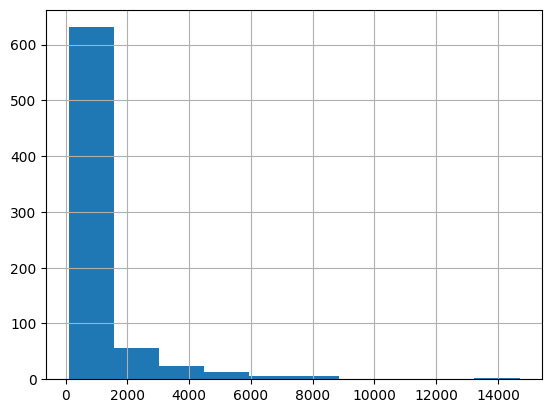

In [85]:
# распределение цен старых автомобилей
data[data['year'] < 1995]['sellingprice'].hist();

Большинство авто были выпущены позже 2010 года, доля таких машин в данных – 60 %. Автомобили, выпущенные до 1995 года, составляют меньше пятой части процента, их цена чаще всего ниже 2000 $.

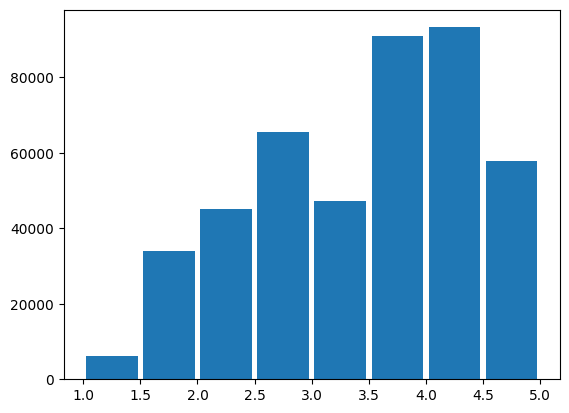

In [86]:
# состояние автомобиля
data['condition'].hist(bins=8, rwidth=0.9, grid=False);

In [87]:
# процент авто с состоянием от 3.5 до 4.5
data[(data['condition'] <= 4.5) & ((data['condition'] >= 3.5))].shape[0] / data.shape[0] * 100

44.07794910002817

Состояние авто оценивается по пятибалльной шкале. 44 % авто имеют оценку от 3,5 до 4,5.

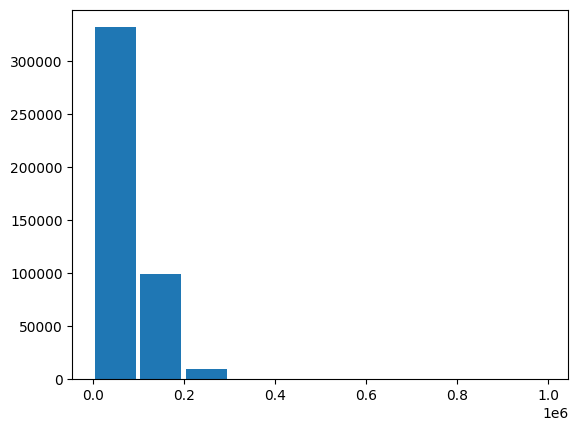

In [88]:
# пробег авто
data['odometer'].hist(bins=10, rwidth=0.9, grid=False);

In [89]:
data[data['odometer'] <= 100_000].shape[0] / data.shape[0] * 100

75.34776801533722

75 % машин имеют пробег менее 100 000 км.

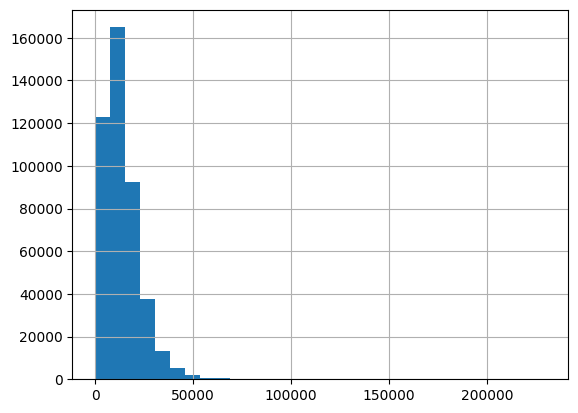

In [90]:
# цена авто
data['sellingprice'].hist(bins=30);

In [91]:
# процент авто дешевле 50 000
data[data['sellingprice'] < 50_000].shape[0] / data.shape[0] * 100

99.37192778418849

99 % автомобилей проданы по цене до 50 000 $.

In [92]:
# количество производителей авто
len(data['make'].unique())

55

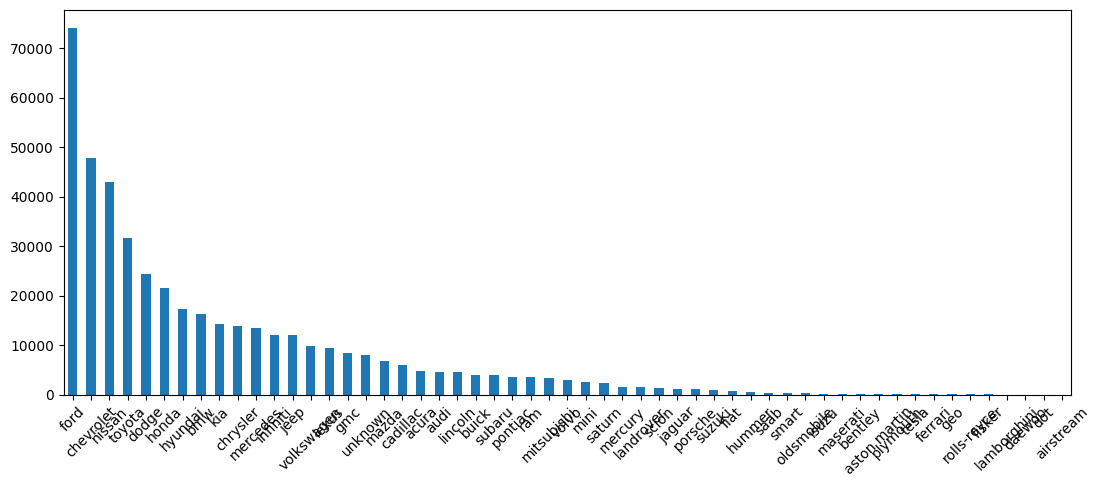

In [93]:
# распределение количества авто по производителям
data['make'].value_counts().plot(kind='bar', figsize=(13, 5), rot=45);

In [94]:
# процент авто, для которых производитель не указан
data[data['make'] == 'unknown'].shape[0] / data.shape[0] * 100

1.8269746227023689

В базе содержатся данные о машинах от 54 производителей.  Больше всего машин марки Ford. Следующие по популярности
Chevrolet, Nissan  и Toyota. Производитель не указан примерно для 2% всех авто.

In [95]:
# количество различных моделей
len(data['model'].unique())

840

In [96]:
# процент авто, для которых не указана модель
data[data['model'] == 'unknown'].shape[0] / data.shape[0] * 100

1.8451466940459207

Количество моделей, представленных в данных: 839. Нет данных о модели у почти 2% записей.

In [97]:
# количество уникальных типов корпусов
len(data['body'].unique())

10

In [98]:
# процент авто, для которых не указан тип корпуса
data[data['body'] == 'unknown'].shape[0] / data.shape[0] * 100

2.076386301892621

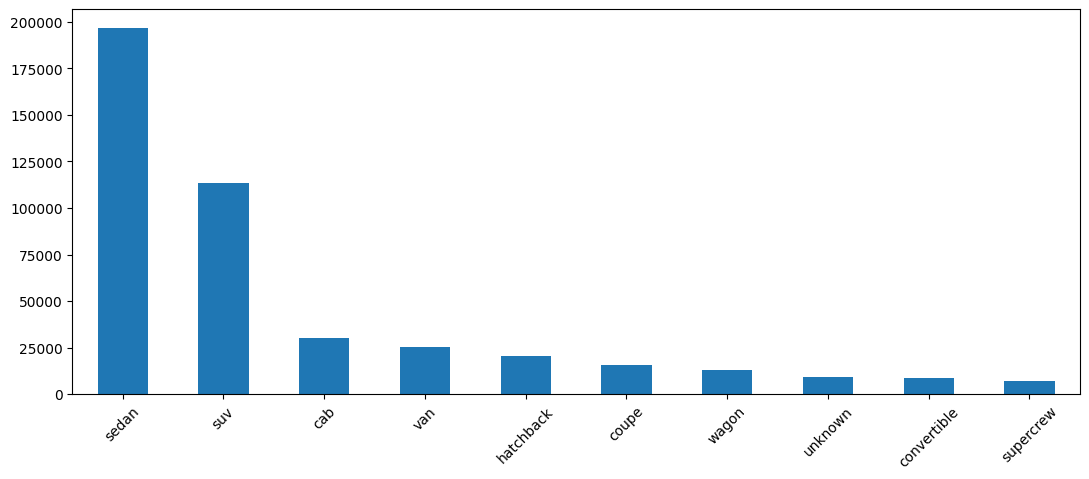

In [99]:
# найдем самые часто встречающиеся типу корпуса
data['body'].value_counts().plot(kind='bar', figsize=(13, 5), rot=45);

В данных видим 9 типов корпуса авто. Самый часто встречающийся тип – седан. Для 2% тип корпуса не указан.

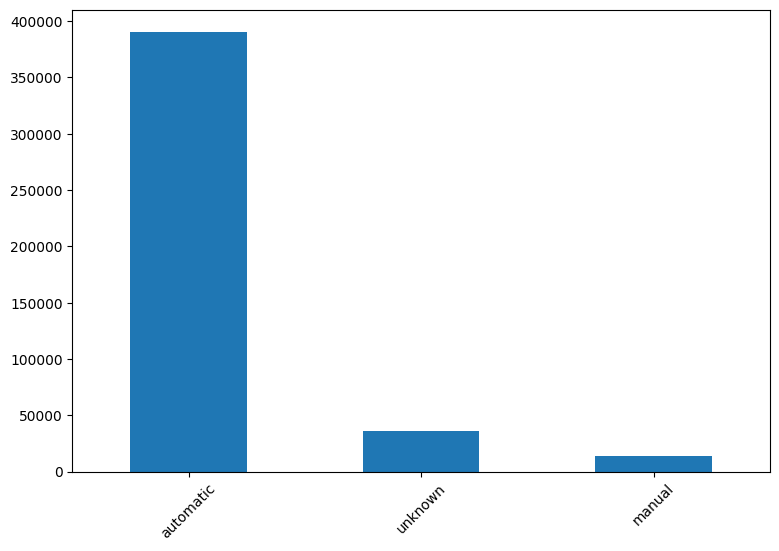

In [100]:
# распределение авто в зависимости от типа трансмиссии
data['transmission'].value_counts().plot(kind='bar', figsize=FIGSIZE, rot=45);

In [101]:
# количество авто, для которых не указан тип коробки передач
data[data['transmission'] == 'unknown'].shape[0] / data.shape[0] * 100

8.105425271899618

In [102]:
# количество авто с автоматической коробкой передач
data[data['transmission'] == 'automatic'].shape[0] / data.shape[0] * 100

88.77851879446479

Большинство (88 %) машин имеют автоматическую коробку передач. Для 8 % авто тип коробки передач не указан.

In [103]:
# количество штатов, в которых авто были выставлены на продажу
len(data['state'].unique())

38

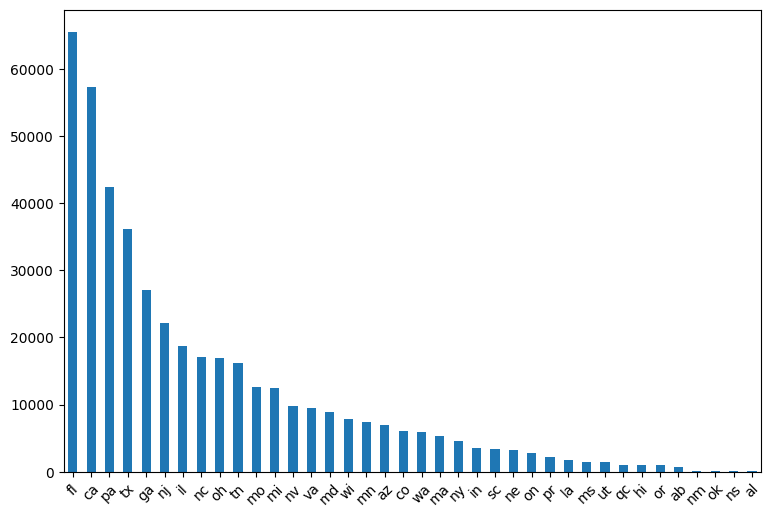

In [104]:
# распределение количества авто по штатам
data['state'].value_counts().plot(kind='bar', figsize=FIGSIZE, rot=45);

В данных имеются предложения из 38 штатов. По количеству предложений лидируют Флорида, Калифорния, Пенсильвания и Техас.

In [105]:
# количество цветов корпуса авто
len(data['color'].unique())

20

In [106]:
# процент авто, для которых цвет не указан
data[data['color'] == 'unknown'].shape[0] / data.shape[0] * 100

4.56709583041823

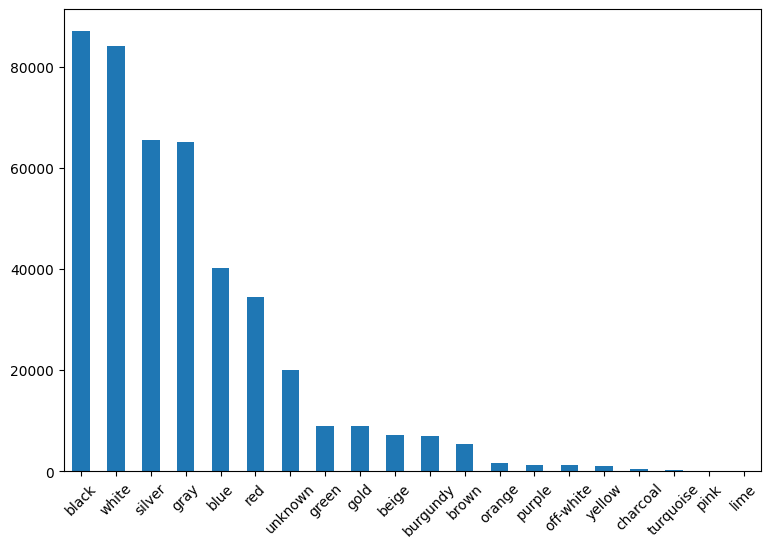

In [107]:
# распределение количества авто по цветам корпуса
data['color'].value_counts().plot(kind='bar', figsize=FIGSIZE, rot=45);

Всего насчитывается 19 цветов. Для 4,5 % предложений цвет не указан.

In [108]:
# количество цветов салона
len(data['interior'].unique())

17

In [109]:
# процент авто, для которых цвет салона не указан
data[data['interior'] == 'unknown'].shape[0] / data.shape[0] * 100

3.2139579679989825

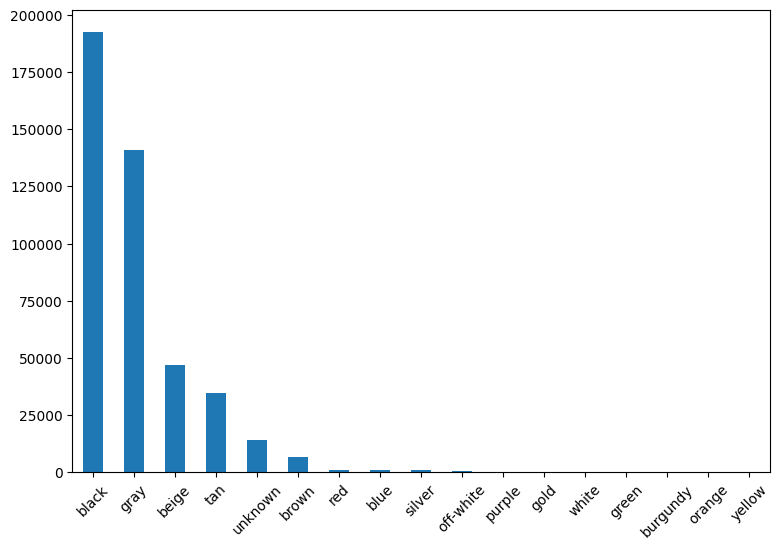

In [110]:
# найдем самые распространённые цвета отделки салона
data['interior'].value_counts().plot(kind='bar', figsize=FIGSIZE, rot=45);

Всего цветов  салона: 16, для 3,2 % предложений цвет не указан. Самые частые цвета: черный и серый, далее идут бежевый и темно-бежевый (цвет загара).

In [111]:
# количество уникальных значений в столбце с уровнем отделки салона
len(data['trim'].unique())

1851

In [112]:
# процент авто, для которых уровень отделки салона не указан
data[data['trim'] == 'unknown'].shape[0] / data.shape[0] * 100

1.8937569848899227

Столбец с уровнем отделки салона насчитывает почти 2 000 значений. Для 2 % авто значение не известно.

In [113]:
# количество продавцов
len(data['seller'].unique())

13025

In [114]:
# первые 10
data['seller'].value_counts()[:10]

nissan-infiniti lt                       15823
ford motor credit company,llc            15276
the hertz corporation                    14692
santander consumer                       12230
avis corporation                         10098
nissan infiniti lt                        7964
wells fargo dealer services               7061
enterprise veh exchange/rental            5516
tdaf remarketing                          5404
ge fleet services for itself/servicer     5368
Name: seller, dtype: int64

In [115]:
# последние 10
data['seller'].value_counts()[13015:]

778025 alberta ltd                1
pacific auto resellers            1
tower auto sales                  1
iezzi's auto sales                1
u.s. auto credit                  1
bay shore motors                  1
thrifty rent a car systems inc    1
volvo of wichita                  1
wright way hyundai                1
studio city auto group            1
Name: seller, dtype: int64

In [116]:
# общая статистика
data['seller'].value_counts().describe()

count    13025.000000
mean        33.799309
std        348.417589
min          1.000000
25%          1.000000
50%          3.000000
75%          9.000000
max      15823.000000
Name: seller, dtype: float64

В данных представлены предложения от 13025 продавцов. 75 % из них упоминаются не больше 3х раз. Десятка самых активных продавцов имеет от 5 до почти 16 тысяч предложений.

In [117]:
# проверим, что уникальные номера транспортного средства не содержат явных дубликатов
len(data['vin'].unique()) == data.shape[0]

True

## Выводы анализа данных

В данных 4 числовых характеристики:
    
- год выпуска

- состояние автомобилей на момент аукциона

- расстояние, пройденное автомобилем с момента выпуска

- цена, по которой автомобиль был продан на аукционе.

Остальные характеристики качественные.

Большинство авто были выпущены позже 2010 года, доля таких машин в данных – 60 %. Автомобили, выпущенные до 1995 года, составляют меньше пятой части процента, их цена чаще всего ниже 2000 $.

99 % автомобилей проданы по цене до 50 000 $.

Состояние авто оценивается по пятибалльной шкале. 44 % авто имеют оценку от 3,5 до 4,5.

75 % машин имеют пробег менее 100 000 км.

В базе содержатся данные о машинах от 54 производителей.  Больше всего машин марки Ford. Следующие по популярности

Chevrolet, Nissan  и Toyota. Производитель не указан примерно для 2% всех авто.

Количество моделей, представленных в данных: 839. Нет данных о модели у почти 2% записей.

В данных видим 9 типов корпуса авто. Самый часто встречающийся тип – седан. Для 2% тип корпуса не указан.

Большинство (88 %) машин имеют автоматическую коробку передач. Для 8 % авто тип коробки передач не указан.

В данных имеются предложения из 38 штатов. По количеству предложений лидируют Флорида, Калифорния, Пенсильвания и Техас.

Цвет корпуса. Всего насчитывается 19 цветов. Для 4,5 % предложений цвет не указан. Преобладают нейтральные цвета: черный, белый, серебристый и серый. похожая ситуация относительно цвета салона: 16 цветов, для 3,2 % предложений цвет не указан. Самые частые цвета: черный и серый, далее идут бежевый и темно-бежевый (цвет загара).

В данных представлены предложения от 13025 продавцов. 75 % из них упоминаются не больше 3х раз. Десятка самых активных продавцов имеет от 5 до почти 16 тысяч предложений.


# Преобразование типов

Одним из признаков, который оказывает влияние на конечную цену может быть возраст автомобиля на момент продажи. Возможно, цена может отличаться в зависимости от месяца продажи или дня недели. Выделим эти характеристики в отдельные столбцы.

Сначала преобразуем тип столбца, содержащего дату продажи.

In [118]:
# обрезаем дату
data['saledate'] = data['saledate'].apply(lambda x: x[:15])

In [119]:
data['saledate']

0         Tue Jun 02 2015
1         Wed Feb 25 2015
2         Wed Jun 10 2015
3         Wed Jun 17 2015
4         Tue Feb 03 2015
               ...       
440231    Tue Jan 20 2015
440232    Wed Feb 11 2015
440233    Tue Mar 03 2015
440234    Wed Jan 14 2015
440235    Thu Jan 15 2015
Name: saledate, Length: 440236, dtype: object

In [120]:
# преобразуем тип столбца
data['saledate_new'] = pd.to_datetime(
    data['saledate'],
    format='%a %b %d %Y'
)

In [121]:
# преобразуем тип столбца для тестового набора данных
test['saledate'] = test['saledate'].apply(lambda x: x[:15])
test['saledate_new'] = pd.to_datetime(
    test['saledate'],
    format='%a %b %d %Y'
)

# Добавление новых признаков и обработка выбросов

Добавим новые признаки, такие как год продажи, месяц, регион производства, количество продаж для продавцов и т.п.

Чтобы наша модель смогла найти закономерность в формировании цены, предоставим ей наиболее типичные данные. Будем искать аномальные значения в числовых характеристиках данных

In [122]:
# создаем столбец с годом продажи
data['sale_year'] = pd.DatetimeIndex(data['saledate_new']).year

In [123]:
# создаем столбец с месяцем продажи
data['sale_month'] = pd.DatetimeIndex(data['saledate_new']).month

In [124]:
# создаем столбец с днем недели продажи
data['sale_wd'] = pd.DatetimeIndex(data['saledate_new']).weekday

In [125]:
# посмотрим распределение продаж по дням недели
data.groupby('sale_wd')['vin'].count()

sale_wd
0     12512
1    129240
2    130655
3    121366
4     46335
5         5
6       123
Name: vin, dtype: int64

In [126]:
# создаем столбец с возрастом авто на момент продажи
data['age'] = data['sale_year'] - data['year']

In [127]:
# создаем новые столбцы в тестовом наборе данных
test['sale_year'] = pd.DatetimeIndex(test['saledate_new']).year
test['sale_month'] = pd.DatetimeIndex(test['saledate_new']).month
test['sale_wd'] = pd.DatetimeIndex(test['saledate_new']).weekday
test['age'] = test['sale_year'] - test['year']

## Возраст авто

In [128]:
# список значений столбца с возрастом авто
data['age'].unique()

array([ 4,  1,  3, 12,  8,  2,  5, 15, 10,  9, 11,  7,  6,  0, 13, 14, 17,
       19, 16, 21, 18, 20, -1, 22, 26, 24, 27, 28, 25, 23, 30, 29, 32, 31,
       33])

In [129]:
# список значений столбца с возрастом авто на тесте
test['age'].unique()

array([10,  1,  2, 12,  4,  8,  0,  6,  3,  5,  9, 13,  7, 14, 11, 18, -1,
       17, 16, 15, 20, 23, 22, 19, 24, 21, 29, 26, 25, 33, 31, 28, 27])

In [130]:
# количество записей с отрицательным возрастом
data[data['age'] < 0].shape[0]

166

Количество строк, в которых возраст отрицательный, составляет меньше одного процента, поэтому удалим их в тренировочном датасете, чтобы предоставить модели менее зашумленные данные. В тренировочной выборке ничего удалять не будем.

In [131]:
data = data[data['age'] >= 0]

Посмотрим на другие числовые характеристики.

## Состояние авто

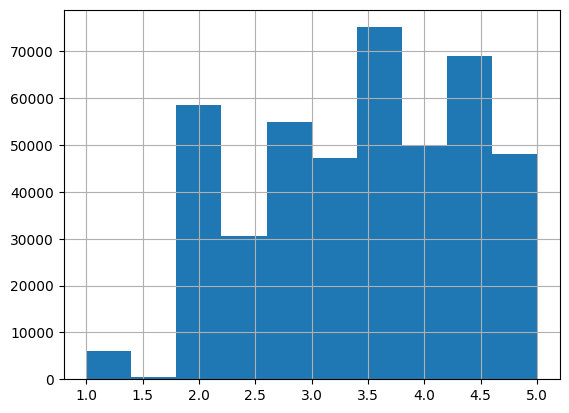

In [132]:
data['condition'].hist();

In [133]:
# процент авто с оценкой состояния ниже 1.5.
len(data[data['condition'] <= 1.5]) / data.shape[0] * 100

1.4288635898834277

Удалим авто с очень низкой оценкой состояния

In [134]:
data = data[data['condition'] > 1.5]

## Пробег автомобиля

Построим ящик с усами и будем искать выбросы

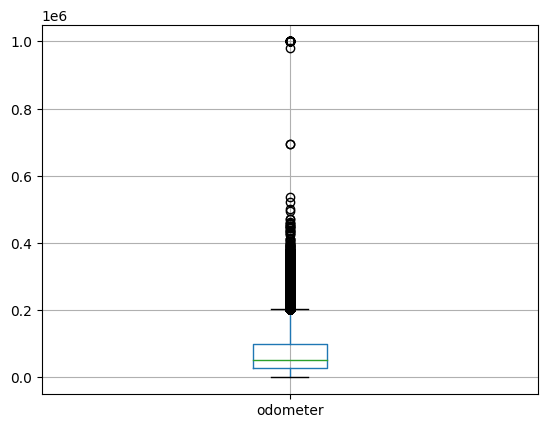

In [135]:
data.boxplot(column='odometer');

In [136]:
# процент авто с пробегом более 200 000 км
len(data[data['odometer'] >= 200_000]) / data.shape[0] * 100

2.052874485340563

Оставим только авто с пробегом меньше 200 000

In [137]:
data = data[data['odometer'] < 200_000]

## Цена

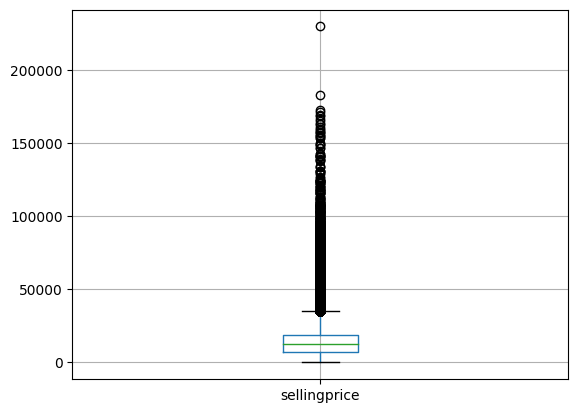

In [138]:
data.boxplot(column='sellingprice');

In [139]:
# процент авто с ценой выше 35 000
len(data[data['sellingprice'] >= 35_000]) / data.shape[0] * 100

3.1223153995156245

Оставим авто ценой ниже 35 000

In [140]:
data = data[data['sellingprice'] < 35_000]

Проверим, какая часть данных осталась после удаления выбросов.

In [141]:
data.shape[0] / 440_236 * 100

93.49780572238527

Мы удалили менее 10 % данных.Теперь добавим несколько характеристик, которые можем рассчитать по имеющимся данным.

## Медианная цена по штату

In [142]:
# вычислим медианное значение цены для каждого штата
state_median_price = pd.pivot_table(
    data,
    values='sellingprice',
    index='state',
    aggfunc='median'
)

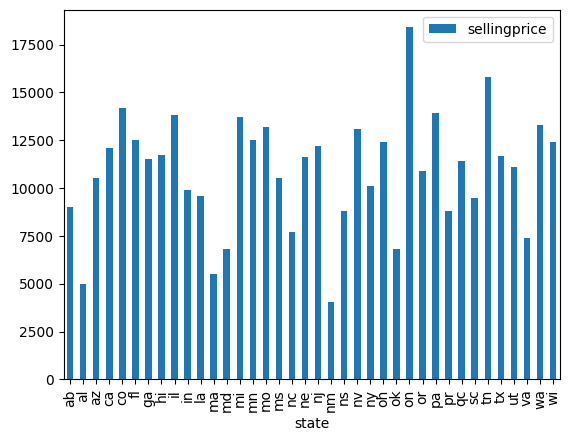

In [143]:
# посмотрим, меняется ли она от штата к штату
state_median_price.plot(kind='bar');

Медианная цена отличается по штату. Запишем ее в отдельную колонку.

In [144]:
# для обучающего набора данных
for state in data['state'].unique():
    data.loc[data['state'] == state, 'state_m_price'] = state_median_price.loc[state, 'sellingprice']

In [145]:
# для тестового набора данных
for state in test['state'].unique():
    test.loc[test['state'] == state, 'state_m_price'] = state_median_price.loc[state, 'sellingprice']

In [146]:
# контроль пропусков
data['state_m_price'].isna().sum(), test['state_m_price'].isna().sum()

(0, 0)

In [147]:
# посмотрим коэффициент корреляции этого признака с целевой переменной
data['sellingprice'].corr(data['state_m_price'])

0.24247026297030125

## Медианная цена модели

In [148]:
# вычислим медианное значение цены для каждой модели
model_median_price = pd.pivot_table(
    data,
    values='sellingprice',
    index='model',
    aggfunc='median'
)

In [149]:
# для обучающего набора данных
for model in data['model'].unique():
    data.loc[data['model'] == model, 'model_m_price'] = model_median_price.loc[model, 'sellingprice']

In [150]:
# для тестового набора данных
for model in test['model'].unique():
    if model in model_median_price.index:
        test.loc[test['model'] == model, 'model_m_price'] = model_median_price.loc[model, 'sellingprice']
    else:
        test.loc[test['model'] == model, 'model_m_price'] = 0

In [151]:
# контроль пропусков
data['model_m_price'].isna().sum(), test['model_m_price'].isna().sum()

(0, 0)

In [152]:
# процент моделей авто в тестовом наборе, которых не было в обучающем датасете
test[test['model_m_price'] == 0].shape[0] / test.shape[0] * 100

0.11266786603427283

In [153]:
# посмотрим коэффициент корреляции этого признака с целевой переменной
data['sellingprice'].corr(data['model_m_price'])

0.6226205866269083

## Медианная цена для производителя

In [154]:
# вычислим медианное значение цены для каждого производителя
make_median_price = pd.pivot_table(
    data,
    values='sellingprice',
    index='make',
    aggfunc='median'
)

In [155]:
# для обучающего набора данных
for make in data['make'].unique():
    data.loc[data['make'] == make, 'make_m_price'] = make_median_price.loc[make, 'sellingprice']

In [156]:
# для тестового набора данных
for make in test['make'].unique():
    if make in make_median_price.index:
        test.loc[test['make'] == make, 'make_m_price'] = make_median_price.loc[make, 'sellingprice']
    else:
        test.loc[test['make'] == make, 'make_m_price'] = 0

In [157]:
# контроль пропусков
data['make_m_price'].isna().sum(), test['make_m_price'].isna().sum()

(0, 0)

In [158]:
# процент производителе1 авто в тестовом наборе, которых не было в обучающем датасете
test[test['make_m_price'] == 0].shape[0] / test.shape[0] * 100

0.017263624634283742

In [159]:
# посмотрим коэффициент корреляции этого признака с целевой переменной
data['sellingprice'].corr(data['make_m_price'])

0.38219026628733904

## Медианная цена для продавца

In [160]:
# вычислим медианное значение цены для каждого продавца
seller_median_price = pd.pivot_table(
    data,
    values='sellingprice',
    index='seller',
    aggfunc='median'
)

In [161]:
# для обучающего набора данных
for seller in data['seller'].unique():
    data.loc[data['seller'] == seller, 'seller_m_price'] = seller_median_price.loc[seller, 'sellingprice']

In [162]:
# для тестового набора данных
for seller in test['seller'].unique():
    if seller in seller_median_price.index:
        test.loc[test['seller'] == seller, 'seller_m_price'] = seller_median_price.loc[seller, 'sellingprice']
    else:
        test.loc[test['seller'] == seller, 'seller_m_price'] = 0

In [163]:
# контроль пропусков
data['seller_m_price'].isna().sum(), test['seller_m_price'].isna().sum()

(0, 0)

In [164]:
# посмотрим коэффициент корреляции этого признака с целевой переменной
data['sellingprice'].corr(data['seller_m_price'])

0.6999540829076588

## Медианная цена для года производства

In [165]:
# вычислим медианное значение цены для года производства
year_median_price = pd.pivot_table(
    data,
    values='sellingprice',
    index='year',
    aggfunc='median'
)

In [166]:
# для обучающего набора данных
for year in data['year'].unique():
    data.loc[data['year'] == year, 'year_m_price'] = year_median_price.loc[year, 'sellingprice']

In [167]:
# для тестового набора данных
for year in test['year'].unique():
    test.loc[test['year'] == year, 'year_m_price'] = year_median_price.loc[year, 'sellingprice']

In [168]:
# контроль пропусков
data['year_m_price'].isna().sum(), test['year_m_price'].isna().sum()

(0, 0)

In [169]:
# посмотрим коэффициент корреляции этого признака с целевой переменной
data['sellingprice'].corr(data['year_m_price'])

0.6537266227630952

## Регион производства

По первым символам столбца с уникальным номером автомобиля vin можно восстановить континент, на котором авто было произведено.

In [170]:
# функция определяет регион, где произведен автомобиль
def region_from_vin(row):
    if row[0] in '12345':
        return 1 # nourth america
    if row[0] in '67':
        return 2 # оceania
    if row[0] in '89':
        return 3 # south america
    if row[0] in 'abcdefgh':
        return 4 # africa
    if row[0] in 'jklmn':
        return 5 # asia
    else:
        return 6 # europe

In [171]:
# для обучающего набора данных
data['region'] = data['vin'].apply(region_from_vin)

In [172]:
# для тестового набора данных
test['region'] = test['vin'].apply(region_from_vin)

In [173]:
# контроль пропусков
data['region'].isna().sum(), test['region'].isna().sum()

(0, 0)

## Класс авто

Добавим 3 класса авто в зависимости от стоимости. Класс будем определять по медианной стоимости модели.

In [174]:
# треть диапазона разброса медианных цен разных моделей авто
(data['model_m_price'].max() - data['model_m_price'].min()) / 3

11366.666666666666

In [175]:
# для обучающего набора данных
data.loc[data['model_m_price'] > 22_800, 'model_class'] = 1
data.loc[((data['model_m_price'] > 11_400) & (data['model_m_price'] <= 22_800)), 'model_class'] = 2
data.loc[data['model_m_price'] <= 11_400, 'model_class'] = 3

In [176]:
# для тестового набора данных
test.loc[test['model_m_price'] > 22_800, 'model_class'] = 1
test.loc[((test['model_m_price'] > 11_400) & (test['model_m_price'] <= 22_800)), 'model_class'] = 2
test.loc[test['model_m_price'] <= 11_400, 'model_class'] = 3

In [177]:
# контроль пропусков
data['model_class'].isna().sum(), test['model_class'].isna().sum()

(0, 0)

In [178]:
data.reset_index(inplace=True, drop=True)

In [179]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 411611 entries, 0 to 411610
Data columns (total 27 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   year            411611 non-null  int64         
 1   make            411611 non-null  object        
 2   model           411611 non-null  object        
 3   trim            411611 non-null  object        
 4   body            411611 non-null  object        
 5   transmission    411611 non-null  object        
 6   vin             411611 non-null  object        
 7   state           411611 non-null  object        
 8   condition       411611 non-null  float64       
 9   odometer        411611 non-null  float64       
 10  color           411611 non-null  object        
 11  interior        411611 non-null  object        
 12  seller          411611 non-null  object        
 13  sellingprice    411611 non-null  int64         
 14  saledate        411611 non-null  obj

In [180]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110058 entries, 0 to 110057
Data columns (total 26 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   year            110058 non-null  int64         
 1   make            110058 non-null  object        
 2   model           110058 non-null  object        
 3   trim            110058 non-null  object        
 4   body            110058 non-null  object        
 5   transmission    110058 non-null  object        
 6   vin             110058 non-null  object        
 7   state           110058 non-null  object        
 8   condition       110058 non-null  float64       
 9   odometer        110058 non-null  float64       
 10  color           110058 non-null  object        
 11  interior        110058 non-null  object        
 12  seller          110058 non-null  object        
 13  saledate        110058 non-null  object        
 14  saledate_new    110058 non-null  dat

## Вывод

На данном этапе мы удалили часть выбросов, чтобы снизить зашумленность данных и повысить точность модели. Количество удаленных наблюдений не превышает 10 % от первоначального количества строк датасета.

Были созданы новые характеристики, которые коррелируют с целевой переменной.

Из уникального номера авто удалось извлечь информацию о регионе производства машины.


# Подготовка данных к обучению на них модели

Для того, чтобы передать данные модели для обучения, необходимо выделить целевой признак и характеристики для обучения в отдельные переменные.

Категориальные переменные нужно привести к числовому виду. Все характеристики необходимо масштабировать.

Тестовые данные необходимо также привести к тому виду, который будет привычным для выбранной нами модели.


In [181]:
# выделяем целевой признак
target = data['sellingprice']

## Удаление признаков

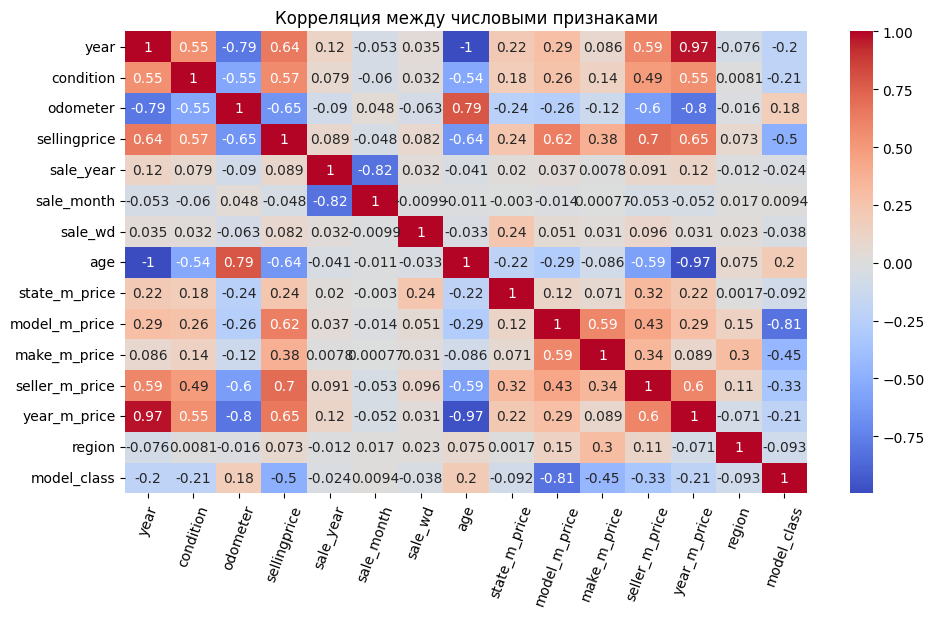

In [182]:
# посмотрим на корреляцию признаков между собой
chart = sns.heatmap(
    data.corr(),
    cmap='coolwarm',
    annot=True
)
chart.set_title('Корреляция между числовыми признаками')
chart.set_xticklabels(chart.get_xticklabels(), rotation=70)
fig = chart.get_figure()
fig.set_size_inches(11, 6)
chart;

Часть характеристик не будем использовать для обучения модели, так как они:

- либо неинформативные сами по себе (например, столбец vin, данные о регионе производства авто мы уже извлекли из него и поместили в отдельный столбец),

- либо имеется сильная корреляция с другими числовыми данными, а это может негативно отразиться на точности модели (в этом случае оставим тот столбец, корреляция которого с целевой переменной выше).


In [183]:
data = data.drop([
    'year', # вместо него будем использовать year_m_price
    'age', # вместо него будем использовать year_m_price
    'vin', # неинформативный
    'state', # вместо него будем использовать stae_m_price
    'seller', # вместо него будем использовать seller_m_price
    'saledate', # вместо него будем использовать year_m_price, month_m_price
    'saledate_new', # вместо него будем использовать year_m_price, month_m_price
    'sale_month', # очень низкая корреляция с целевым признаком
    'sale_wd', # очень низкая корреляция с целевым признаком
    'sellingprice' # целевой признак
], axis=1)

По аналогии удалим эти же признаки из тестового набора данных (за исключением sellingprice, эта колонка в датасете отсутствует).

In [184]:
test = test.drop([
    'year',
    'age',
    'vin',
    'state',
    'seller',
    'saledate',
    'saledate_new',
    'sale_month',
    'sale_wd'
], axis=1)

In [185]:
# контроль размерности
data.shape, test.shape

((411611, 17), (110058, 17))

In [186]:
# контроль порядка оставшихся характеристик
for c_data, c_test in zip(data.columns, test.columns):
    print(f'{c_data:20} {c_test:20}')

make                 make                
model                model               
trim                 trim                
body                 body                
transmission         transmission        
condition            condition           
odometer             odometer            
color                color               
interior             interior            
sale_year            sale_year           
state_m_price        state_m_price       
model_m_price        model_m_price       
make_m_price         make_m_price        
seller_m_price       seller_m_price      
year_m_price         year_m_price        
region               region              
model_class          model_class         


## Преобразование категориальных признаков

Приведем категориальные признаки к числовому виду с помощью порядкового кодирования средствами ScikitLearn.

In [187]:
# список категориальных переменных для преобразования
cat_columns = [
    'make',
    'model',
    'trim',
    'body',
    'transmission',
    'color',
    'interior'
]

In [188]:
# категориальные характеристики обучающего набора данных
cat_features = data.loc[:, cat_columns]

In [189]:
# категориальные характеристики тестового набора данных
cat_features_test = test.loc[:, cat_columns]

In [190]:
# будем использовать OrdinalEncoder
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

In [191]:
# обучаем и применяем его к обучающему набору
enc.fit(cat_features)
cat_features = enc.transform(cat_features)
cat_features = pd.DataFrame(cat_features)
cat_features.columns = cat_columns
cat_features

,make,model,trim,body,transmission,color,interior
0,12.0,224.0,1304.0,6.0,0.0,1.0,1.0
1,12.0,297.0,1273.0,4.0,0.0,1.0,1.0
2,32.0,618.0,67.0,4.0,0.0,1.0,1.0
3,16.0,352.0,535.0,6.0,0.0,6.0,0.0
4,12.0,297.0,1304.0,4.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...
411606,22.0,492.0,763.0,4.0,0.0,18.0,0.0
411607,30.0,170.0,1231.0,9.0,0.0,18.0,1.0
411608,3.0,32.0,450.0,2.0,0.0,7.0,1.0
411609,37.0,6.0,1357.0,0.0,0.0,18.0,6.0


In [192]:
# обучаем и применяем его к тестовому набору
cat_features_test = enc.transform(cat_features_test)
cat_features_test = pd.DataFrame(cat_features_test)
cat_features_test.columns = cat_columns
cat_features_test

,make,model,trim,body,transmission,color,interior
0,5.0,188.0,535.0,4.0,0.0,15.0,1.0
1,14.0,612.0,175.0,8.0,0.0,18.0,6.0
2,32.0,475.0,1224.0,6.0,0.0,7.0,1.0
3,6.0,365.0,1032.0,4.0,0.0,15.0,1.0
4,32.0,689.0,1442.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...
110053,21.0,743.0,1379.0,6.0,0.0,11.0,1.0
110054,24.0,375.0,535.0,4.0,0.0,7.0,1.0
110055,32.0,440.0,238.0,4.0,0.0,15.0,6.0
110056,32.0,20.0,535.0,2.0,1.0,17.0,1.0


In [193]:
# заменяем категориальные столбцы преобразованными данными
data = data.drop(cat_columns, axis=1)

In [194]:
data

,condition,odometer,sale_year,state_m_price,model_m_price,make_m_price,seller_m_price,year_m_price,region,model_class
0,4.2,111041.0,2015,6800.0,20000.0,13500.0,7500.0,14500.0,1,2.0
1,3.5,31034.0,2015,13200.0,12700.0,13500.0,16800.0,17000.0,1,2.0
2,2.2,35619.0,2015,12200.0,9800.0,12000.0,13500.0,14000.0,1,3.0
3,2.8,131301.0,2015,11700.0,17100.0,13600.0,14100.0,2900.0,1,2.0
4,2.0,127709.0,2015,6800.0,12700.0,13500.0,650.0,6900.0,1,2.0
...,...,...,...,...,...,...,...,...,...,...
411606,4.5,20434.0,2015,12100.0,14300.0,12200.0,15100.0,14300.0,5,2.0
411607,2.9,14675.0,2015,12400.0,18500.0,12500.0,13750.0,17000.0,6,2.0
411608,3.7,102552.0,2015,12100.0,16200.0,16750.0,16750.0,8200.0,6,2.0
411609,3.0,29367.0,2015,11700.0,27400.0,23200.0,30600.0,17000.0,1,1.0


In [195]:
data = pd.merge(data, cat_features, left_index=True, right_index=True)

In [196]:
data.shape

(411611, 17)

In [197]:
# для тестового набора данных
test = test.drop(cat_columns, axis=1)
test = pd.merge(test, cat_features_test, left_index=True, right_index=True)
test.head()

,condition,odometer,sale_year,state_m_price,model_m_price,make_m_price,seller_m_price,year_m_price,region,model_class,make,model,trim,body,transmission,color,interior
0,2.7,116970.0,2015,12100.0,9350.0,13000.0,5850.0,4100.0,1,3.0,5.0,188.0,535.0,4.0,0.0,15.0,1.0
1,4.4,6286.0,2015,13900.0,20200.0,16500.0,19600.0,17000.0,1,2.0,14.0,612.0,175.0,8.0,0.0,18.0,6.0
2,4.6,11831.0,2015,12400.0,14300.0,12000.0,13500.0,14300.0,5,2.0,32.0,475.0,1224.0,6.0,0.0,7.0,1.0
3,2.3,57105.0,2015,12500.0,7700.0,10500.0,7750.0,14300.0,1,3.0,6.0,365.0,1032.0,4.0,0.0,15.0,1.0
4,2.9,31083.0,2015,15800.0,11650.0,12000.0,18750.0,14300.0,1,2.0,32.0,689.0,1442.0,0.0,0.0,1.0,1.0


## Масштабирование признаков

In [198]:
# будем использовать StandardScaler
sscaler = StandardScaler()

In [199]:
# список колонок
column_names = data.columns

In [200]:
# обучающий набор
data = sscaler.fit_transform(data)
data = pd.DataFrame(data)
data.columns = column_names
data.head()

,condition,odometer,sale_year,state_m_price,model_m_price,make_m_price,seller_m_price,year_m_price,region,model_class,make,model,trim,body,transmission,color,interior
0,0.843234,0.987912,0.326474,-2.630643,1.284962,0.239840,-0.830039,0.608302,-0.575553,-0.624238,-0.594491,-0.604061,0.760470,0.732598,-0.341462,-1.260447,-0.717286
1,0.064782,-0.745585,0.326474,0.544922,-0.100025,0.239840,0.826065,1.133110,-0.575553,-0.624238,-0.594491,-0.270079,0.691053,-0.267017,-0.341462,-1.260447,-0.717286
2,-1.380916,-0.646242,0.326474,0.048740,-0.650225,-0.211186,0.238415,0.503340,-0.575553,1.233457,0.913936,1.198527,-2.009489,-0.267017,-0.341462,-1.260447,-0.717286
3,-0.713671,1.426881,0.326474,-0.199351,0.734762,0.269908,0.345260,-1.826806,-0.575553,-0.624238,-0.292805,-0.018449,-0.961518,0.732598,-0.341462,-0.520792,-0.962973
4,-1.603331,1.349054,0.326474,-2.630643,-0.100025,0.239840,-2.049858,-0.987114,-0.575553,-0.624238,-0.594491,-0.270079,0.760470,-0.267017,-0.341462,-1.260447,-0.717286


In [201]:
# тестовый набор
test = pd.DataFrame(sscaler.transform(test))
test.columns = column_names
test.head()

,condition,odometer,sale_year,state_m_price,model_m_price,make_m_price,seller_m_price,year_m_price,region,model_class,make,model,trim,body,transmission,color,interior
0,-0.824878,1.116374,0.326474,-0.000878,-0.735601,0.089498,-1.123864,-1.574898,-0.575553,1.233457,-1.122440,-0.768765,-0.961518,-0.267017,-0.341462,0.810587,-0.717286
1,1.065649,-1.281795,0.326474,0.892249,1.322907,1.141892,1.324677,1.133110,-0.575553,-0.624238,-0.443648,1.171076,-1.767649,1.732213,-0.341462,1.254380,0.511151
2,1.288064,-1.161652,0.326474,0.147976,0.203534,-0.211186,0.238415,0.566317,1.523077,-0.624238,0.913936,0.544288,0.581329,0.732598,-0.341462,-0.372861,-0.717286
3,-1.269708,-0.180709,0.326474,0.197594,-1.048646,-0.662213,-0.785520,0.566317,-0.575553,1.233457,-1.047019,0.041027,0.151392,-0.267017,-0.341462,0.810587,-0.717286
4,-0.602463,-0.744523,0.326474,1.834995,-0.299235,-0.211186,1.173312,0.566317,-0.575553,-0.624238,0.913936,1.523359,1.069487,-2.266247,-0.341462,-1.260447,-0.717286


# Подбор гиперпараметров моделей

Перед нами стоит задача предсказания цены подержанного авто по его характеристикам. Это задача регрессии.

Для выбора модели в отдельном ноутбуке разделила обработанный обучающий набор данных на тренировочный и валидационный в отношении 3 : 1 и рассчитала значение MAPE на валидационной выборке для нескольких моделей. Лучише результаты показали GradientBoostingRegressor и RandomForestRegressor: MAPE для них составила 29 %. Также проверила модели SGDRegressor (MAPE 42 %) и ElasticNet (MAPE 48 %).

Для дальнейшей подборки гиперпараметров оставила GradientBoostingRegressor и RandomForestRegressor.

Сначала подберем гиперпараметры для моделей.


In [202]:
## Гиперпараметры градиентного бустинга

In [203]:
# список гиперпараметров и их значений
search_space = {
    'loss' : ['squared_error', 'absolute_error', 'huber', 'quantile'],
    'learning_rate' : [0.1],
    'n_estimators' : [100, 200, 500]
}

In [204]:
gbr = GradientBoostingRegressor(random_state=RANDOM_STATE)

Ошибка показаний модели оценивается с помощью метрики MAPE, но GridSearch не принимает ее в виде функции по умолчанию. Воспользуемся функцией make_scorer, чтобы GridSearch мог с ней работать.

In [205]:
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

In [206]:
GS = GridSearchCV(
    estimator=gbr,
    param_grid=search_space,
    scoring=mape_scorer,
    refit='mape_scorer',
    cv=3,
    verbose=4
)

In [207]:
data.shape

(411611, 17)

In [208]:
# GS.fit(data, target)
# Fitting 3 folds for each of 12 candidates, totalling 36 fits
# [CV 1/3] END learning_rate=0.1, loss=squared_error, n_estimators=100;, score=-0.313 total time= 1.1min
# [CV 2/3] END learning_rate=0.1, loss=squared_error, n_estimators=100;, score=-0.256 total time= 1.1min
# [CV 3/3] END learning_rate=0.1, loss=squared_error, n_estimators=100;, score=-0.281 total time= 1.1min
# [CV 1/3] END learning_rate=0.1, loss=squared_error, n_estimators=200;, score=-0.282 total time= 2.3min
# [CV 2/3] END learning_rate=0.1, loss=squared_error, n_estimators=200;, score=-0.232 total time= 2.2min
# [CV 3/3] END learning_rate=0.1, loss=squared_error, n_estimators=200;, score=-0.256 total time= 2.4min
# [CV 1/3] END learning_rate=0.1, loss=squared_error, n_estimators=500;, score=-0.250 total time= 6.0min
# [CV 2/3] END learning_rate=0.1, loss=squared_error, n_estimators=500;, score=-0.204 total time= 6.3min
# [CV 3/3] END learning_rate=0.1, loss=squared_error, n_estimators=500;, score=-0.236 total time= 5.8min
# [CV 1/3] END learning_rate=0.1, loss=absolute_error, n_estimators=100;, score=-0.304 total time= 1.6min
# [CV 2/3] END learning_rate=0.1, loss=absolute_error, n_estimators=100;, score=-0.241 total time= 1.2min
# [CV 3/3] END learning_rate=0.1, loss=absolute_error, n_estimators=100;, score=-0.260 total time= 1.2min
# [CV 1/3] END learning_rate=0.1, loss=absolute_error, n_estimators=200;, score=-0.269 total time= 2.5min
# [CV 2/3] END learning_rate=0.1, loss=absolute_error, n_estimators=200;, score=-0.214 total time= 2.5min
# [CV 3/3] END learning_rate=0.1, loss=absolute_error, n_estimators=200;, score=-0.235 total time= 2.4min
# [CV 1/3] END learning_rate=0.1, loss=absolute_error, n_estimators=500;, score=-0.243 total time= 6.2min
# [CV 2/3] END learning_rate=0.1, loss=absolute_error, n_estimators=500;, score=-0.189 total time= 7.2min
# [CV 3/3] END learning_rate=0.1, loss=absolute_error, n_estimators=500;, score=-0.232 total time= 7.1min
# [CV 1/3] END learning_rate=0.1, loss=huber, n_estimators=100;, score=-0.322 total time= 1.5min
# [CV 2/3] END learning_rate=0.1, loss=huber, n_estimators=100;, score=-0.248 total time= 1.3min
# [CV 3/3] END learning_rate=0.1, loss=huber, n_estimators=100;, score=-0.269 total time= 1.6min
# [CV 1/3] END learning_rate=0.1, loss=huber, n_estimators=200;, score=-0.286 total time= 3.3min
# [CV 2/3] END learning_rate=0.1, loss=huber, n_estimators=200;, score=-0.224 total time= 3.0min
# [CV 3/3] END learning_rate=0.1, loss=huber, n_estimators=200;, score=-0.248 total time= 2.9min
# [CV 1/3] END learning_rate=0.1, loss=huber, n_estimators=500;, score=-0.255 total time= 6.7min
# [CV 2/3] END learning_rate=0.1, loss=huber, n_estimators=500;, score=-0.197 total time= 6.4min
# [CV 3/3] END learning_rate=0.1, loss=huber, n_estimators=500;, score=-0.238 total time= 6.4min
# [CV 1/3] END learning_rate=0.1, loss=quantile, n_estimators=100;, score=-0.769 total time= 1.2min
# [CV 2/3] END learning_rate=0.1, loss=quantile, n_estimators=100;, score=-0.597 total time= 1.2min
# [CV 3/3] END learning_rate=0.1, loss=quantile, n_estimators=100;, score=-0.653 total time= 1.2min
# [CV 1/3] END learning_rate=0.1, loss=quantile, n_estimators=200;, score=-0.698 total time= 2.4min
# [CV 2/3] END learning_rate=0.1, loss=quantile, n_estimators=200;, score=-0.517 total time= 2.4min
# [CV 3/3] END learning_rate=0.1, loss=quantile, n_estimators=200;, score=-0.578 total time= 2.5min
# [CV 1/3] END learning_rate=0.1, loss=quantile, n_estimators=500;, score=-0.540 total time= 6.0min
# [CV 2/3] END learning_rate=0.1, loss=quantile, n_estimators=500;, score=-0.425 total time= 6.0min
# [CV 3/3] END learning_rate=0.1, loss=quantile, n_estimators=500;, score=-0.492 total time= 6.1min
# GridSearchCV
# estimator: GradientBoostingRegressor

# GradientBoostingRegressor


In [209]:
# GS.best_estimator_

Гиперпараметры случайного леса

In [210]:
search_space = {
    'criterion' : ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
#     'max_depth' : [5, 10],
#     'n_estimators' : [100, 200, 500]
}

При первом запуске GridSearchCV стало понятно, что max_depth лучше установить равным 10, а  большой разницы в производительности между 200 и 500 деревьями нет, поэтому для увеличения скорости обучения установила  n_estimators=200.

In [211]:
rfr = RandomForestRegressor(
    random_state=RANDOM_STATE,
    max_depth=10,
    n_estimators=200)

In [212]:
GSrfr = GridSearchCV(
    estimator=rfr,
    param_grid=search_space,
    scoring=mape_scorer,
    refit='mape_scorer',
    cv=3,
    verbose=4
)

In [213]:
# GSrfr.fit(data, target)

In [215]:
# GSrfr.best_estimator_
# RandomForestRegressor(criterion='poisson', max_depth=10, n_estimators=200,
#                       random_state=12345)

## Создание дополнительных характеристик

Решила добавить две дополнительные характеристики – предсказания цены градиентным бустингом и случайным лесом. Чтобы получить предсказания этих моделей для обучающего набора данных, использовала кросс-валидацию.

Для повышения точности предсказаний разбила обучающий набор на три части – в зависимости от класса машины, который рассчитала ранее на основе медианной цены модели. Для каждого класса отдельно настроила свои модели, которые сгенерировали предсказания. После введения такого разделения, MAPE на Kaggle улучшился на 10 % (с 32 до 21,9).

Таким образом, на первом этапе градиентный бустинг генерирует предсказания на обучающих данных для каждого класса. Затем то же самое делает случайный лес. Их показания записываются в новые столбцы. Потом датасет собирается в единый, который и передается финальной модели градиентного бустинга.

In [216]:
# разбиваем данные по классам
class_1 = data[data['model_class'] >= 0]
class_2 = data[(data['model_class'] >= -1) & (data['model_class'] < 0)]
class_3 = data[data['model_class'] < -1]

target_1 = target[class_1.index]
target_2 = target[class_2.index]
target_3 = target[class_3.index]

In [222]:
# контроль правильности разбиения
class_1.shape[0], class_2.shape[0], class_3.shape[0]

(152031, 245862, 13718)

In [223]:
target_1.shape[0], target_2.shape[0], target_3.shape[0]

(152031, 245862, 13718)

In [224]:
gbr_model = GradientBoostingRegressor(loss='absolute_error', n_estimators=500,
                          random_state=12345)

In [225]:
# формируем предсказания бустинга
gbr_class_1 = cross_val_predict(gbr_model, class_1, target_1, cv=3)
gbr_class_2 = cross_val_predict(gbr_model, class_2, target_2, cv=3)
gbr_class_3 = cross_val_predict(gbr_model, class_3, target_3, cv=3)

In [226]:
rfr_model = RandomForestRegressor(
    criterion='poisson',
    max_depth=10,
    n_estimators=200,
    random_state=RANDOM_STATE
    )

In [227]:
# формируем предсказания случайного леса
rfr_class_1 = cross_val_predict(rfr_model, class_1, target_1, cv=3)
rfr_class_2 = cross_val_predict(rfr_model, class_2, target_2, cv=3)
rfr_class_3 = cross_val_predict(rfr_model, class_3, target_3, cv=3)

In [228]:
# записываем предсказания в датасеты
# градиентный бустинг
class_1.loc[:, 'gbr'] = gbr_class_1
class_2.loc[:, 'gbr'] = gbr_class_2
class_3.loc[:, 'gbr'] = gbr_class_3

# решающий лес
class_1.loc[:, 'rfr'] = rfr_class_1
class_2.loc[:, 'rfr'] = rfr_class_2
class_3.loc[:, 'rfr'] = rfr_class_3

## Cобираем датасет для обучения финальной модели

In [229]:
features = pd.concat([class_1, class_2, class_3])
features.head()

,condition,odometer,sale_year,state_m_price,model_m_price,make_m_price,seller_m_price,year_m_price,region,model_class,make,model,trim,body,transmission,color,interior,gbr,rfr
2,-1.380916,-0.646242,0.326474,0.048740,-0.650225,-0.211186,0.238415,0.503340,-0.575553,1.233457,0.913936,1.198527,-2.009489,-0.267017,-0.341462,-1.260447,-0.717286,9069.091398,10074.425356
6,-0.046426,1.064742,0.326474,-2.184079,-1.693708,-2.767001,-1.453304,-0.231391,-0.575553,1.233457,1.140201,-0.169427,-1.440718,1.232406,-0.341462,0.810587,-0.717286,6562.227203,5325.981453
8,-1.714538,2.538886,0.326474,0.147976,-0.403583,-0.391597,-1.720418,-2.120698,1.523077,1.233457,-0.217384,-0.585761,-0.218085,-0.267017,-0.341462,-1.260447,2.230962,-363.358893,1129.432563
9,-0.380048,0.803007,0.326474,-0.000878,-1.314259,-1.925086,0.029176,-0.987114,-0.575553,1.233457,1.894414,1.656037,1.253106,1.232406,-0.341462,-1.112516,0.511151,7594.217353,9670.233382
10,1.510479,0.201818,0.326474,0.544922,-1.276315,-0.511870,-0.830039,0.608302,-0.575553,1.233457,-1.197862,0.265207,-0.648022,-0.267017,-0.341462,1.254380,2.230962,12490.827428,11994.253676


In [230]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 411611 entries, 2 to 411609
Data columns (total 19 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   condition       411611 non-null  float64
 1   odometer        411611 non-null  float64
 2   sale_year       411611 non-null  float64
 3   state_m_price   411611 non-null  float64
 4   model_m_price   411611 non-null  float64
 5   make_m_price    411611 non-null  float64
 6   seller_m_price  411611 non-null  float64
 7   year_m_price    411611 non-null  float64
 8   region          411611 non-null  float64
 9   model_class     411611 non-null  float64
 10  make            411611 non-null  float64
 11  model           411611 non-null  float64
 12  trim            411611 non-null  float64
 13  body            411611 non-null  float64
 14  transmission    411611 non-null  float64
 15  color           411611 non-null  float64
 16  interior        411611 non-null  float64
 17  gbr       

In [231]:
# упорядочим индексы, которые перемешались после разбиения на классы и слияния
features.sort_index(inplace=True)

## Готовим модели для предсказаний теста

In [232]:
gbr_model_1_class = GradientBoostingRegressor(loss='absolute_error', n_estimators=500,
                          random_state=RANDOM_STATE)
gbr_model_2_class = GradientBoostingRegressor(loss='absolute_error', n_estimators=500,
                          random_state=RANDOM_STATE)
gbr_model_3_class = GradientBoostingRegressor(loss='absolute_error', n_estimators=500,
                          random_state=RANDOM_STATE)
rfr_model_1_class = RandomForestRegressor(criterion='poisson', max_depth=10, n_estimators=200,
                      random_state=RANDOM_STATE)
rfr_model_2_class = RandomForestRegressor(criterion='poisson', max_depth=10, n_estimators=200,
                      random_state=RANDOM_STATE)
rfr_model_3_class = RandomForestRegressor(criterion='poisson', max_depth=10, n_estimators=200,
                      random_state=RANDOM_STATE)

In [233]:
# обучаем модели
gbr_model_1_class.fit(class_1.loc[:, 'condition' : 'interior'], target_1)
gbr_model_2_class.fit(class_2.loc[:, 'condition' : 'interior'], target_2)
gbr_model_3_class.fit(class_3.loc[:, 'condition' : 'interior'], target_3)
rfr_model_1_class.fit(class_1.loc[:, 'condition' : 'interior'], target_1)
rfr_model_2_class.fit(class_2.loc[:, 'condition' : 'interior'], target_2)
rfr_model_3_class.fit(class_3.loc[:, 'condition' : 'interior'], target_3)

RandomForestRegressor(criterion='poisson', max_depth=10, n_estimators=200,
                      random_state=12345)

In [234]:
# разбиваем тест на классы
test_1 = test[test['model_class'] >= 0]
test_2 = test[(test['model_class'] >= -1) & (test['model_class'] < 0)]
test_3 = test[test['model_class'] < -1]

In [235]:
# формируем предсказания
gbr_test_1 = gbr_model_1_class.predict(test_1)
gbr_test_2 = gbr_model_2_class.predict(test_2)
gbr_test_3 = gbr_model_3_class.predict(test_3)

rfr_test_1 = rfr_model_1_class.predict(test_1)
rfr_test_2 = rfr_model_2_class.predict(test_2)
rfr_test_3 = rfr_model_3_class.predict(test_3)

In [236]:
# дописываем их в столбцы
test_1.loc[:, 'gbr'] = gbr_test_1
test_1.loc[:, 'rfr'] = rfr_test_1

test_2.loc[:, 'gbr'] = gbr_test_2
test_2.loc[:, 'rfr'] = rfr_test_2

test_3.loc[:, 'gbr'] = gbr_test_3
test_3.loc[:, 'rfr'] = rfr_test_3

In [237]:
# собираем датасет
test = pd.concat([test_1, test_2, test_3])
test.sort_index(inplace=True)

# Финальная модель. обучение и предсказания

In [238]:
# инициализация модели
GBR = GradientBoostingRegressor(loss='absolute_error', n_estimators=500,
                          random_state=RANDOM_STATE)

In [239]:
# обучение
GBR.fit(features, target)

GradientBoostingRegressor(loss='absolute_error', n_estimators=500,
                          random_state=12345)

In [240]:
# предсказание на тестовой выборке
final_predictions = GBR.predict(test)

In [241]:
# формируем файл для отправки на Kaggle
vins = pd.read_csv('test.csv')['vin']
final = pd.merge(vins, pd.DataFrame(final_predictions), left_index=True, right_index=True)
final.columns = ['vin', 'sellingprice']
# final.to_csv('submission.csv', index=False)

Такая последовательность действий позволила добиться лучшего результата на Kaggle в 20,508 % MAPE.

Также пробовала такие варианты, но все они приводили к незначительному снижению MAPE:
- передать финальной модели только два столбца с предсказаниями бустинга и леса (21,21 %)
- снова масштабировать два столбца с предсказаниями, чтобы они были в том же диапазоне, что и остальные характеристики (20,68 %)
- предоставлять решающему лесу вместе с остальными характеристиками предсказания градиентного бустинга для генерации своих предсказаний (21,714 %)


# Анализ важности признаков моделей

In [242]:
# упорядоченный список весов характеристик финальной модели
sorted(zip(GBR.feature_importances_, features.columns), reverse=True)

[(0.8658465529132141, 'gbr'),
 (0.08865560786866611, 'rfr'),
 (0.011518952121683074, 'model_m_price'),
 (0.008029787026256906, 'trim'),
 (0.005389823507459146, 'seller_m_price'),
 (0.0044197100654104395, 'model'),
 (0.003775940780625833, 'year_m_price'),
 (0.003202839699375994, 'odometer'),
 (0.0023471678710530195, 'make'),
 (0.0019991960501089838, 'state_m_price'),
 (0.0016894189855830323, 'make_m_price'),
 (0.0013756195901494226, 'body'),
 (0.000998255324870212, 'condition'),
 (0.00022657453663920505, 'interior'),
 (0.00020637701619310753, 'region'),
 (0.00016833939720318767, 'color'),
 (9.448069328833556e-05, 'sale_year'),
 (5.477863951993042e-05, 'transmission'),
 (5.77912700012868e-07, 'model_class')]

In [243]:
# упорядоченный список весов моделей первого этапа

# градиентный бустинг
sorted(zip(gbr_model_2_class.feature_importances_, features.columns), reverse=True)

[(0.21134382696764864, 'odometer'),
 (0.19727984929786566, 'model_m_price'),
 (0.13092869141250227, 'seller_m_price'),
 (0.1037691974126957, 'year_m_price'),
 (0.08779321802559908, 'trim'),
 (0.08193278190352413, 'condition'),
 (0.07155623882578033, 'model'),
 (0.046349247484723535, 'body'),
 (0.03525609029624717, 'make'),
 (0.02100760840097377, 'make_m_price'),
 (0.004045219370613807, 'interior'),
 (0.003973696579821772, 'region'),
 (0.003640202304667843, 'state_m_price'),
 (0.0008234208204962175, 'color'),
 (0.0001797702813902485, 'sale_year'),
 (0.0001209406154498107, 'transmission'),
 (0.0, 'model_class')]

In [244]:
# случайный лес
sorted(zip(rfr_model_2_class.feature_importances_, features.columns), reverse=True)

[(0.4664876456561101, 'odometer'),
 (0.18329540481213916, 'model_m_price'),
 (0.1664315430770359, 'year_m_price'),
 (0.06209058408391615, 'seller_m_price'),
 (0.029573284766815647, 'model'),
 (0.024334170461990233, 'condition'),
 (0.02084242971707633, 'make_m_price'),
 (0.018167355445399252, 'body'),
 (0.017399001010865417, 'trim'),
 (0.007337581706620778, 'make'),
 (0.0033325611670760283, 'region'),
 (0.0003416339282082998, 'state_m_price'),
 (0.0001665969066300345, 'color'),
 (0.00013708326185249146, 'interior'),
 (3.80117620403859e-05, 'transmission'),
 (2.5112236223834665e-05, 'sale_year'),
 (0.0, 'model_class')]

Самыми важными в принятии решений для моделей оказались следующие характеристики: пробег авто, медианная цена модели и медианная цена продавца или года производства.

Финальная модель градиентного бустинга при формировании предсказаний опиралась в основной на предсказания моделей предыдущего шага и на среднюю цену модели.

# Общий вывод

Перед нами стоит задача регрессии: необходимо на основе имеющихся данных предсказать цену автомобиля на вторичном рынке.

Есть датасет, содержащий 440 236 строк, 14 характеристик и целевой признак.

Данные содержат пропуски и неявные дубликаты. Видно, что датасет, доступный для обучения, очень сильно по своим характеристикам похож на тестовый. Поэтому при обработке пропусков и дубликатов:
- одновременно обрабатывались обучающий датасет и тестовый;

- закономерности данных, необходимые для выработки правил заполнения пропусков, вырабатывались на тренировочном датасете, а применялись к обоим датасетам (по той же логике, по которой устроены трансформеры данных библиотеки Scikit Learn)
- часть обучающих данных, которые являются выбросами, были удалены  в целях уменьшения зашумленности и повышения качества модели.

В некоторых случаях кажется возможным заполнить пропуски по имеющимся данным других столбцов. Например, зная модель машины, можно заполнить пропуски в данных о типе кузова и т.п.

Так как модели придется вырабатывать прогнозы на данных, которые тоже могут содержать отсутствующие значения, то часть пропусков заполнили значением 'unknown'.

После обработки пропусков и дубликатов был проведен разведывательный анализ данных.
Основные характеристики машин в обучающем датасете:

Большинство авто были выпущены позже 2010 года, доля таких машин в данных – 60 %. Автомобили, выпущенные до 1995 года, составляют меньше пятой части процента, их цена чаще всего ниже 2000 $.

99 % автомобилей проданы по цене до 50 000 $.

Состояние авто оценивается по пятибалльной шкале. 44 % авто имеют оценку от 3,5 до 4,5.

75 % машин имеют пробег менее 100 000 км.

В базе содержатся данные о машинах от 54 производителей. Больше всего машин марки Ford. Следующие по популярности
Chevrolet, Nissan и Toyota. Производитель не указан примерно для 2% всех авто.

Количество моделей, представленных в данных: 839. Нет данных о модели у почти 2% записей.

В данных видим 9 типов корпуса авто. Самый часто встречающийся тип – седан. Для 2% тип корпуса не указан.

Большинство (88 %) машин имеют автоматическую коробку передач. Для 8 % авто тип коробки передач не указан.

В данных имеются предложения из 38 штатов. По количеству предложений лидируют Флорида, Калифорния, Пенсильвания и Техас.

Цвет корпуса. Всего насчитывается 19 цветов. Для 4,5 % предложений цвет не указан. Преобладают нейтральные цвета: черный, белый, серебристый и серый. похожая ситуация относительно цвета салона: 16 цветов, для 3,2 % предложений цвет не указан. Самые частые цвета: черный и серый, далее идут бежевый и темно-бежевый (цвет загара).

В данных представлены предложения от 13 025 продавцов. 75 % из них упоминаются не больше 3х раз. Десятка самых активных продавцов имеет от 5 до почти 16 тысяч предложений.

В целях увеличения точности предсказаний модели были рассчитаны новые характеристики: возраст авто, медианная цена по штату, продавцу, модели авто, производителю, года производства. По уникальному идентификационному номеру удалось восстановить регион производства.

Данные были подготовлены для передачи модели: выделен в отдельную переменную целевой признак. По медианной цене модели были выделены три класса автомобилей.

Были опробованы модели GradientBoostingRegressor,  RandomForestRegressor, SGDRegressor и ElasticNet. Самая низкая MAPE оказалась у GradientBoostingRegressor и RandomForestRegressor, поэтому для них была проведена настройка гиперпараметров с помощью GridSearchCV.

Для повышения точности предсказаний обучающий набор был разбит на три части – в зависимости от класса машины, который рассчитала ранее на основе медианной цены модели. Для каждого класса отдельно были настроены свои модели, которые сгенерировали предсказания. После введения такого разделения, MAPE на Kaggle улучшился на 10 % (с 32 до 21,9).

Таким образом, на первом этапе градиентный бустинг генерирует предсказания на обучающих данных. Затем то же самое делает решающий лес. Их показания дописываются к имеющимся характеристикам в новые столбцы. Потом три датасета, соответствующие отдельным классам цен на модели, собирается в единый, который и передается финальной модели градиентного бустинга.

Такая последовательность действий позволила добиться лучшего результата на Kaggle в 20,508 %.

В результате анализа характеристик выяснилось, что самыми важными в принятии решений для моделей оказались следующие характеристики: пробег авто, медианная цена модели и медианная цена продавца или года производства. Финальная модель градиентного бустинга при формировании предсказаний опиралась в основной на предсказания моделей предыдущего шага и на среднюю цену модели.
